## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [4]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,3"  # specify which GPU(s) to be used

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
train, test = keras.datasets.cifar10.load_data()

In [6]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [7]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation=None, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation=None, 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZEs = [256, 128, 32, 16, 2]
MOMENTUM = 0.95

In [12]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for BATCH_SIZE in BATCH_SIZEs:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.6f" % (BATCH_SIZE))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    #optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-BATCH_SIZE-%s" % str(BATCH_SIZE)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with BATCH_SIZE = 256.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 133s 3ms/step - loss: 2.2014 - acc: 0.1870 - val_loss: 2.1288 - val_acc: 0.2311
Epoch 19/50
15860/50000 [========>.....................] - ETA: 1:27 - loss: 2.2074 - acc: 0.1830

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 139s 3ms/step - loss: 2.2038 - acc: 0.1840 - val_loss: 2.1101 - val_acc: 0.2173
Epoch 21/50
50000/50000 [==============================] - 134s 3ms/step - loss: 2.2074 - acc: 0.1841 - val_loss: 2.1309 - val_acc: 0.2039
Epoch 22/50
50000/50000 [==============================] - 134s 3ms/step - loss: 2.2020 - acc: 0.1876 - val_loss: 2.1379 - val_acc: 0.2209
Epoch 23/50
50000/50000 [==============================] - 134s 3ms/step - loss: 2.2059 - acc: 0.1802 - val_loss: 2.1238 - val_acc: 0.2231
Epoch 24/50
50000/50000 [==============================] - 134s 3ms/step - loss: 2.2007 - acc: 0.1812 - val_loss: 2.1185 - val_acc: 0.2273
Epoch 25/50
50000/50000 [==============================] - 134s 3ms/step - loss: 2.2022 - acc: 0.1800 - val_loss: 2.1088 - val_acc: 0.2220
Epoch 26/50
50000/50000 [==============================] - 142s 3ms/step - loss: 2.2023 - acc: 0.1827 - val_loss: 2.1392 - val_acc: 0.1991
Epoch 27/50
50000/50000 [==============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 133s 3ms/step - loss: 2.1984 - acc: 0.1830 - val_loss: 2.1184 - val_acc: 0.2233
Epoch 47/50
50000/50000 [==============================] - 133s 3ms/step - loss: 2.1962 - acc: 0.1845 - val_loss: 2.1380 - val_acc: 0.2059
Epoch 48/50
38978/50000 [======================>.......] - ETA: 28s - loss: 2.2027 - acc: 0.1823

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 134s 3ms/step - loss: 2.2055 - acc: 0.1771 - val_loss: 2.1263 - val_acc: 0.2055
Epoch 50/50
50000/50000 [==============================] - 139s 3ms/step - loss: 2.2099 - acc: 0.1765 - val_loss: 2.1421 - val_acc: 0.2057


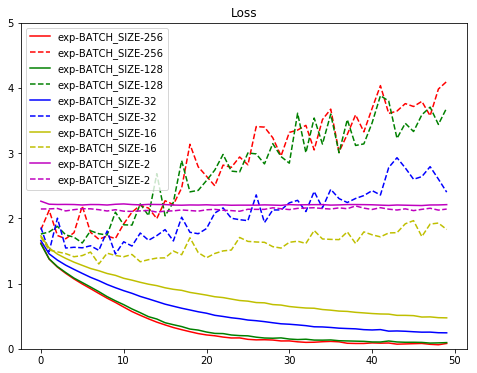

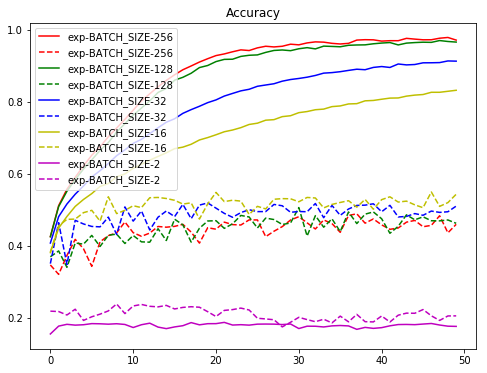

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()